 Let's generate a dataset of observations, actions, and rewards to go for a solo bot flying on ffa_channelpark.



 We'll generate 24 hours of gameplay, which takes about a minute and takes up about 30 megabytes when using half-precision (16 bit) floats. During that time, the bot crashes just over 9000 times. (Coincidentally, both the full replay file and our (obs, act, reward_to_go) dataset are about 30 M.)

In [ ]:
# %load_ext autoreload
# %autoreload 2


In [1]:
import altitude_rl as arl
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


In [7]:


SAMPLES = 30 * 60 * 60 * 2 # 24 hours
obs = np.zeros((SAMPLES, 3))
acts = np.zeros((SAMPLES, 7), dtype=np.int8)
rewards = np.zeros((SAMPLES,))
policy = arl.TurningPolicy()

with arl.SoloChannelparkEnv() as env:
    for i in tqdm(range(SAMPLES)):
        action = policy.act()
        ob, reward = env.step(action)
        if reward < 0:
            rewards[i] = -100
            obs[i] = -100
            acts[i] = -100
            rewards[i-1] = -100
            obs[i-1] = -100
            acts[i-1] = -100
        else:
            rewards[i] = reward
            obs[i] = ob
            acts[i] = action



Creating runtime directory at /Users/danielcesario/Documents/Uni/Semester6/BSP6/autotude/alti_home/run/dc32ae0a-1513-11f0-893a-8222fea70405
Server started with PID 6610
Map loaded, server is ready to receive commands


100%|██████████| 216000/216000 [00:27<00:00, 7907.06it/s]


Shutting down server


In [40]:
mask = np.any(obs == -100, axis=1)

In [41]:

obs = obs[~mask]
acts = acts[~mask]
rewards = rewards[~mask]

(209660, 3) (209660, 7)
[torch.Size([]), torch.Size([2])]


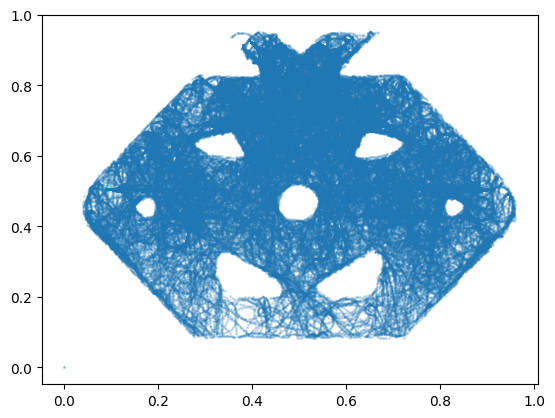

In [44]:
import torch as t
from torch.utils.data import TensorDataset, DataLoader, random_split


def to_torch(x):
    return t.tensor(x, dtype=t.float16)

dataset = TensorDataset(
    to_torch(obs[:-1,2]),
    to_torch(obs[1:,:2]-obs[:-1,:2])
)

print(obs.shape, acts.shape)
print([x.shape for x in next(iter(dataset))])

t.save(dataset, "data/ffa_channelpark.pt")

plt.scatter(obs[:, 0], obs[:, 1], s=1, alpha=0.2)
negative_reward = rewards < 0
plt.scatter(obs[negative_reward, 0], obs[negative_reward, 1], s=2)
plt.show()
